In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time
import talib

plt.style.use('ggplot')

# 資料載入

In [2]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [3]:
settlementDate_ = pd.read_csv('settlementDate.csv', encoding = 'big5')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/8/31,202208W5,15078
1,2022/8/24,202208W4,15097
2,2022/8/17,202208,15452
3,2022/8/10,202208W2,14945
4,2022/8/3,202208W1,14707
...,...,...,...
512,2009/12/16,200912,7752
513,2009/11/18,200911,7786
514,2009/10/21,200910,7705
515,2009/9/16,200909,7445


In [4]:
ftr = pd.read_csv('foi&pc_ratio.csv')
ftr.index = pd.to_datetime(ftr.Date)
ftr = ftr.drop(columns = ['Date'])
ftr

,外資未平倉,PC ratio
Date,,
2007-07-02,-6558,94.00
2007-07-03,-7244,99.37
2007-07-04,-10093,107.74
2007-07-05,-11282,112.52
2007-07-06,-11925,115.57
...,...,...
2022-06-06,8528,105.68
2022-06-07,6617,99.09
2022-06-08,9587,107.31


# 資料處裡

日k整理

In [5]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [6]:
Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


In [7]:
Morning=Morning.drop(columns=['Hour'])
daily = Morning.resample("B").agg(dict(zip(Morning.columns,["first", "max", "min", "last", "sum"])))
daily = daily[daily["close"].isna()==False].copy()
daily

,open,high,low,close,volume
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382
...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478


NameError: name 'ax' is not defined

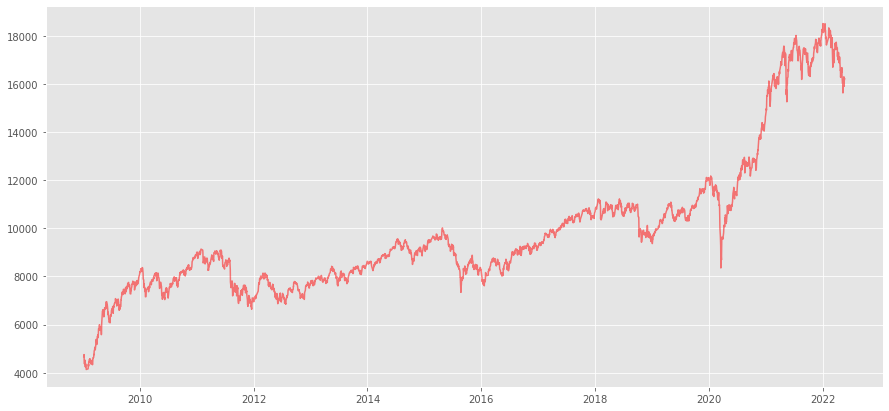

In [8]:
fig, ax1 = plt.subplots(figsize = (15,7))
plt.title('historical plot')
plt.xlabel('date')
ax2 = ax1.twinx()
ax1.set_ylabel('close', color='red')
ax1.plot(daily.close, color='red', alpha=0.75)
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('volume', color='blue')
ax2.fill_between(daily.index, daily.volume, 100, facecolor  = 'blue', label = 'volume', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='blue')

In [9]:
daily = pd.concat([daily, ftr], axis = 1, join = 'inner').dropna()
daily = daily.rename(columns = dict(zip(daily.columns, ['Open', 'High', 'Low', 'Close', 'Volume','Foreign_OI','PC_ratio']))) 
daily

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2009-01-05,4722.0,4797.0,4634.0,4670.0,97869,11435,66.79
2009-01-06,4699.0,4735.0,4638.0,4706.0,90227,12294,68.42
2009-01-07,4758.0,4802.0,4711.0,4752.0,90777,14821,70.11
2009-01-08,4650.0,4650.0,4434.0,4452.0,95219,15009,64.57
2009-01-09,4447.0,4495.0,4344.0,4374.0,146382,18302,64.13
...,...,...,...,...,...,...,...
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


In [74]:
trainData = daily[(daily.index >= '2011-01-01 00:00:00') & (daily.index <= '2019-12-31 00:00:00')].copy()
testData = daily[(daily.index >= '2020-1-1 00:00:00') & (daily.index <= '2022-5-22 00:00:00')].copy()

In [75]:
trainData.head(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53


In [76]:
testData.tail(5)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio
2022-05-16,15996.0,16044.0,15847.0,15921.0,97948,-2540,89.74
2022-05-17,15978.0,16096.0,15963.0,16075.0,76752,91,96.15
2022-05-18,16180.0,16318.0,16159.0,16302.0,51713,1701,103.66
2022-05-19,15871.0,15965.0,15820.0,15911.0,109113,400,88.47
2022-05-20,16069.0,16145.0,16013.0,16135.0,85478,5593,96.77


結算日

In [77]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

# 回測

In [78]:
fund = 1000000
feePaid = 600
K = 0.04
d = 0.02

In [79]:
trainData['macd'], trainData['macdsignal'], trainData['macdhist'] = talib.MACD(trainData['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
trainData['ema10'] = talib.EMA(trainData.Close, 10)
trainData['ATR'] = talib.ATR(trainData['High'], trainData['Low'], trainData['Close'], timeperiod=10)
trainData['Keltner_up'] = trainData['ema10']+2*trainData['ATR']
trainData['Keltner_dn'] = trainData['ema10']-2*trainData['ATR']
trainData['foi'] = talib.MOM(trainData.Foreign_OI, timeperiod=5)

In [80]:
trainData.head(20)

,Open,High,Low,Close,Volume,Foreign_OI,PC_ratio,macd,macdsignal,macdhist,ema10,ATR,Keltner_up,Keltner_dn,foi
2011-01-03,9000.0,9030.0,8995.0,9019.0,61365,-12611,128.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,9030.0,9030.0,8974.0,8978.0,62448,-14207,126.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,8967.0,9005.0,8791.0,8838.0,165831,-15303,117.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,8859.0,8876.0,8815.0,8869.0,82510,-15135,114.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,8866.0,8883.0,8727.0,8753.0,128752,-11883,113.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,8753.0,8799.0,8735.0,8787.0,68285,-9186,113.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3425.0
2011-01-11,8779.0,8950.0,8760.0,8941.0,131177,-7542,116.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6665.0
2011-01-12,8960.0,9003.0,8945.0,8967.0,82510,-11930,119.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0
2011-01-13,8998.0,9017.0,8916.0,8969.0,107227,-12340,122.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2795.0
2011-01-14,8965.0,8981.0,8931.0,8970.0,67139,-12655,122.21,NaN,NaN,NaN,8909.100000,NaN,NaN,NaN,-772.0


In [81]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

              profit  profitfee
2011-01-03       0.0        0.0
2011-01-04       0.0        0.0
2011-01-05       0.0        0.0
2011-01-06       0.0        0.0
2011-01-07       0.0        0.0
...              ...        ...
2019-12-25  271400.0   228200.0
2019-12-26  271400.0   228200.0
2019-12-27  271400.0   228200.0
2019-12-30  271400.0   228200.0
2019-12-31  271400.0   228200.0

[2197 rows x 2 columns]


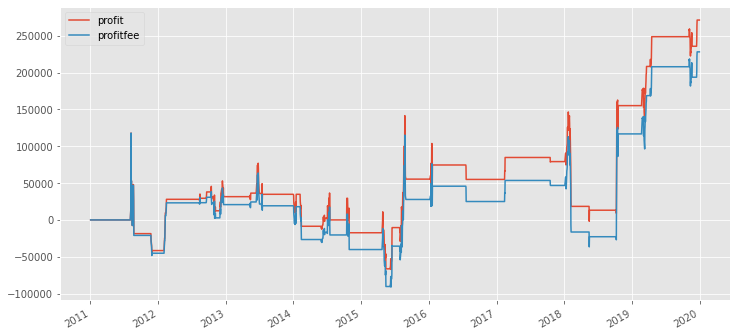

In [105]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = ((df_arr[i,3] > df_arr[i,12]) & (df_arr[i,7] > df_arr[i,8]) & (df_arr[i,6]>105))
    entrySellShort = ((df_arr[i,3] < df_arr[i,13]) & (df_arr[i,7] < df_arr[i,8]) & (df_arr[i,6]<90))
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = ((df_arr[i,3] < df_arr[i,13]) & (df_arr[i,6]<90)) #or ((df_arr[i,3] < df_arr[i,13]) & (df_arr[i,-1]<0))
    exitBuyToCover = ((df_arr[i,3] > df_arr[i,12]) & (df_arr[i,6]>105)) #or ((df_arr[i,3] > df_arr[i,12]) & (df_arr[i,-1]>0))
    exitCondition = date_arr[i] in settlementDate
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-d)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+d)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [97]:
print(buy)
print(sell)
print(sellshort)
print(buytocover)

[263, 393, 419, 472, 573, 618, 735, 832, 855, 1053, 1353, 1490, 1656, 1712, 1724, 1794, 1985, 2014, 2156, 2185]
[273, 397, 422, 486, 578, 622, 742, 846, 866, 1062, 1355, 1493, 1658, 1722, 1732, 1796, 1993, 2020, 2162, 2188]
[143, 154, 220, 437, 448, 598, 604, 755, 926, 930, 1082, 1117, 1136, 1231, 1896, 1900]
[152, 156, 224, 441, 455, 602, 609, 760, 928, 936, 1091, 1131, 1141, 1240, 1899, 1903]


In [98]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

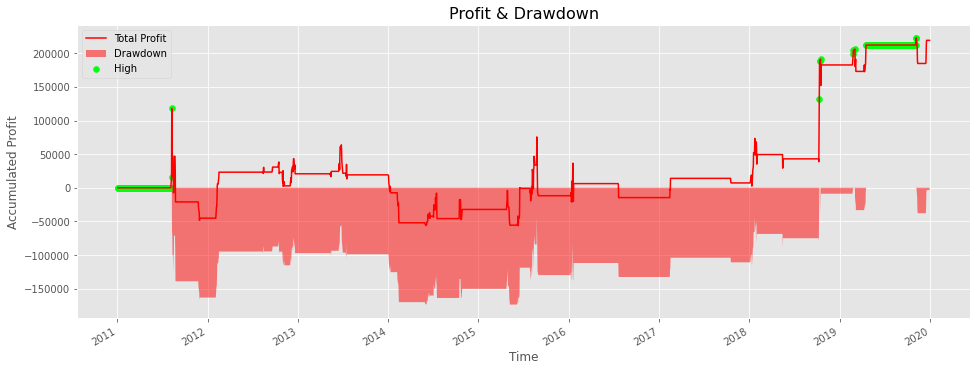

In [99]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

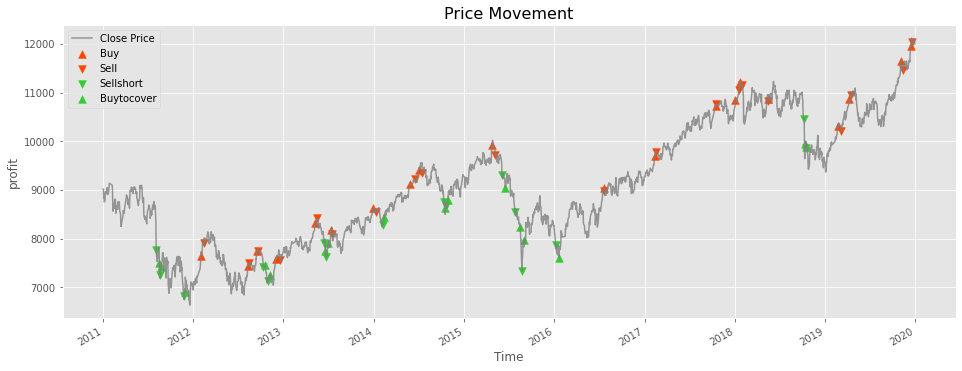

In [100]:
fig, ax = plt.subplots(figsize = (16,6))

trainData['Close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['Close'].iloc[buy].index, trainData['Close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['Close'].iloc[sell].index, trainData['Close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[sellshort].index, trainData['Close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(trainData['Close'].iloc[buytocover].index, trainData['Close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('profit')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [101]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i > 0]) / abs(sum([i for i in profit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in profit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $219200.0
return: 21.92%
mdd: 15.6%
calmarRatio: 1.41
tradeTimes: 36
winRate: 47.22%
profitFactor: 1.55
winLossRatio: 1.73
